In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import cv2
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf 
from keras.utils import np_utils
# for cnn model
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Dense, Conv2D, UpSampling2D, MaxPooling2D, ZeroPadding2D, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

/kaggle/input/fer2013/fer2013.csv


In [2]:
data = pd.read_csv("../input/fer2013/fer2013.csv")
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [3]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [4]:
X = data['pixels']
y = data['emotion']

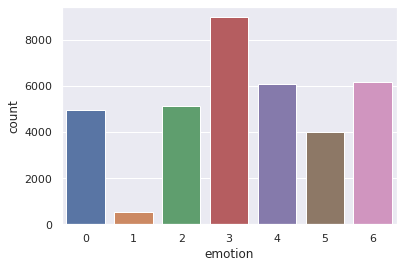

In [5]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [6]:
train_set = data[(data.Usage == 'Training')] 
test_set = data[(data.Usage == 'PrivateTest')] 

In [7]:
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [8]:
X_train=X_train/255
X_test=X_test/255

In [9]:
y_train = train_set.emotion  
y_test = test_set.emotion 

In [10]:
y_train = np_utils.to_categorical(y_train, 7)
y_test = np_utils.to_categorical(y_test, 7)

In [11]:
y_test.shape

(3589, 7)

In [12]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(X_train.shape[1:])))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

2021-11-30 13:52:28.070272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 13:52:28.158455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 13:52:28.159158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 13:52:28.160285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 96)        5

In [14]:
history = model.fit(X_train, y_train, batch_size=128, callbacks=lr_reduce, validation_data=(X_train,y_train), epochs = 50)

2021-11-30 13:52:30.522540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-30 13:52:31.962351: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - 12s 25ms/step - loss: 0.4248 - accuracy: 0.2109 - val_loss: 0.3891 - val_accuracy: 0.2513
Epoch 2/50
225/225 [==============================] - 6s 28ms/step - loss: 0.3985 - accuracy: 0.2283 - val_loss: 0.3895 - val_accuracy: 0.2515
Epoch 3/50
225/225 [==============================] - 5s 22ms/step - loss: 0.3921 - accuracy: 0.2488 - val_loss: 0.3822 - val_accuracy: 0.2702
Epoch 4/50
225/225 [==============================] - 5s 23ms/step - loss: 0.3687 - accuracy: 0.3289 - val_loss: 0.3248 - val_accuracy: 0.4315
Epoch 5/50
225/225 [==============================] - 5s 23ms/step - loss: 0.3191 - accuracy: 0.4494 - val_loss: 0.2914 - val_accuracy: 0.5002
Epoch 6/50
225/225 [==============================] - 5s 22ms/step - loss: 0.2953 - accuracy: 0.4982 - val_loss: 0.2820 - val_accuracy: 0.5301
Epoch 7/50
225/225 [==============================] - 5s 22ms/step - loss: 0.2796 - accuracy: 0.5358 - val_loss: 0.2585 - val_accuracy: 0.5707
Epoch 8/5

In [15]:
# computing the accuracy
print("Accuracy of our model on validation data : " , model.evaluate(X_train,y_train)[1]*100 , "%")

898/898 [==============================] - 3s 3ms/step - loss: 0.0155 - accuracy: 0.9814
Accuracy of our model on validation data :  98.14344048500061 %


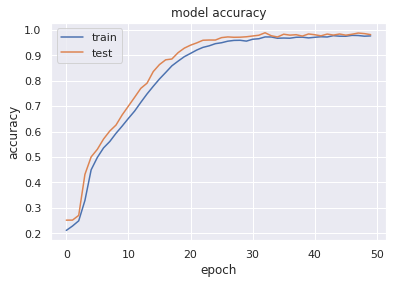

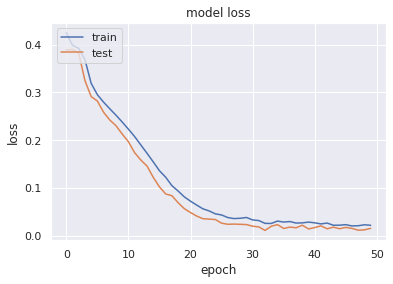

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [18]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,1,1.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [19]:
# model_name = 'Human_Emotion_Model.h5'
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# # Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

In [20]:
#Saving the  model to  use it later on  
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save_weights("fer.h5") 